この演習のコードは
教科書： Francois Chollet さんの「Deep Learning with Python」のサンプルコードを授業用に修正したものです。
元のソースコードは[こちら](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.4-generating-images-with-vaes.ipynb)から見ることができます。


In [1]:
#Tensorflow,Kerasの設定
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras as keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
img_shape = (28, 28, 1) # 学習(インプット)データのサイズ
input_dim = 784 # 28×28=784：損失関数の計算で使用するためのもの
latent_dim = 2  # 潜在空間の次元：今回は可視化が分かりやすいように2次元にする

#エンコーダー(画像→潜在変数)
input_img = keras.Input(shape=img_shape)
# ゼロパディングしてConvolution:28×28×32の特徴マップへ変換
x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img) 
# ゼロパディングしてConvolution:28×28×64の特徴マップへ変換
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
#ハンズオンでの時間を節約するために以下の構造を省略する
#x = layers.Conv2D(64, 3,
#                  padding='same', activation='relu')(x)
#x = layers.Conv2D(64, 3,
#                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)#画像生成(デコード)時に必要な情報

x = layers.Flatten()(x)#28×28×64=50176次元のベクトルに変換
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)#潜在変数(二次元)空間上でのガウス分布の平均を出力
z_log_var = layers.Dense(latent_dim)(x)#潜在変数(二次元)空間上でのガウス分布の分散を出力

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)#Kerasでは一貫して最初の次元がサンプル数(バッチサイズ)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])


Kerasでは事前定義された様々な層(Layer)をレゴブロックのように組み合わせてモデルを作成する。 
しかし、事前定義された層(Layer)だけでは実装できな機能(Layer)が存在しない場合、自分で層(Layer)を実装する必要がある。
独自のLayerを実装するためには、 
重みを持たない層(Layer)に関してはLambdaで定義し、
学習可能な重みを持たせたい場合はカスタム層(Layer)の実装を行う。

In [4]:
#デコーダー(潜在変数→画像)
decoder_input = layers.Input(K.int_shape(z)[1:])#デコーダの入力形式(2次元)

# flattenする前の画像の形状→flaten後の次元を計算:28×28×64=50176次元
# 全結合で2次元→28×28×64=50176次元のベクトルへ変換
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 28×28×64次元のベクトルを28×28×64の特徴マップへ変換
x = layers.Reshape(shape_before_flattening[1:])(x)

# ゼロパディングしてDeconvolution:28×28×32の特徴マップへ変換
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
# ゼロパディングしてConvolution:28×28×1の出力画像へ変換
#各ピクセルの値を[0,1]に限定していたので活性化関数はsigmoidを使う
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)

# デコーダモデルを定義
decoder = Model(decoder_input, x)

# 潜在空間のzをデコードしたz_decodedを定義
z_decoded = decoder(z)

In [5]:
#学習可能な重みを持たせたいのでカスタム層(Layer)で実装
class CustomVariationalLayer(keras.layers.Layer):
    #VAEの損失関数の定義のまま実装
    #ただし、潜在変数のサンプリングはここではデータ毎に１回のみで実装
    #(VAEではこれでも十分であることが知られている)
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
       
        #keras.metrics.binary_crossentropyは平均値を返すので
        #28×28=784次元倍することでavg->sumに変える必要がある
        reconst_loss = input_dim*keras.metrics.binary_crossentropy(x, z_decoded)
        #潜在変数の次元の軸(axis=-1)でKLlossの和を計算
        kl_loss = -0.5*K.sum(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        #データ(バッチ)で平均する
        return K.mean(reconst_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # この出力は使わないのでダミー
        return x

# カスタム層のモデルをcallして損失関数の値を得る
y = CustomVariationalLayer()([input_img, z_decoded])

In [6]:
from keras.datasets import mnist #MNISTを使う場合
#from keras.datasets import fashion_mnist #Fashion-MNISTを使う場合

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

#MNISTを使って学習する場合
(x_train, _), (x_test, y_test) = mnist.load_data()
#Fashion-MNISTを使って学習する場合
#(x_train, _), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.#各ピクセルの値を[0,1]に制限
x_train = x_train.reshape(x_train.shape + (1,))#(データ数, 28, 28)→(データ数, 28, 28, 1)へ変換（チャネル数を追加）
x_test = x_test.astype('float32') / 255.#各ピクセルの値を[0,1]に制限
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=2,
        batch_size=16,
        validation_data=(x_test, None))

C:\Users\the-f\.conda\envs\avilen2\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 12544)        0           conv2d_2[0][0]                   
____________________________________________________________________________________________

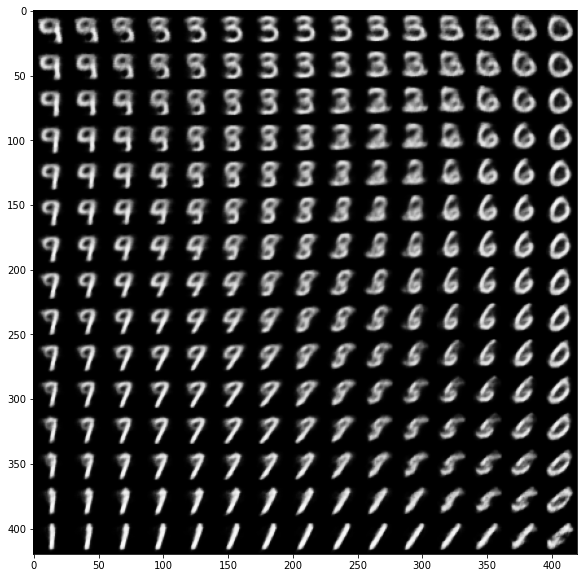

In [7]:

import matplotlib.pyplot as plt
from scipy.stats import norm

#2次元の潜在空間上に画像を配置して可視化
n = 15  # 可視化の画像を15×15のグリッドで配置
digit_size = 28 #画像のサイズ28×28

figure = np.zeros((digit_size * n, digit_size * n))#(28×15)×(28×15)の図を作る
#[0.05,0.95]を15のグリッドで区切った空間を
#ガウス分布のパーセント点関数(Percent point function)
#=累積分布関数の逆関数を使って変換
#norm.ppf(0.25)=-0.6745
#norm.ppf(0.50)=0.0
#norm.ppf(0.75)~0.6745
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

#画像を配置
batch_size=10
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #潜在変数を設定
        z_sample = np.array([[xi, yi]])
        #1つの潜在変数あたりbatch_size個の画像を生成
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        digits = x_decoded.reshape(batch_size,digit_size, digit_size)
        #生成した画像のうち一つだけ表示
        digit  = digits[0]
        #生成した画像の平均を表示
        #digit  = np.mean(digits,axis=0)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()